In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
_include_('curriculum_vqa')

import sys
import os

from cvqa import datasets, models2, trainers, viz
from cvqa.curriculum import teacher, VQAInstanceDistribution

In [3]:
# CLEVR_root = f'{DEV_HOME}/curriculum_vqa/data-bin/CLEVR_v1.0'
# ds = datasets.CLEVR(CLEVR_root, split='val')

In [6]:
prompts = [
    ('shape', 'There is a [shape].', 'TRUE'),
    ('shape', 'There is a [color] item.', 'TRUE'),
#     ('shape', 'This thing is a [shape].', 'TRUE'),
#     ('shape', 'There is 1 [shape] in the image.', 'TRUE'),
#     ('shape', 'There is a item of [color] color.', 'TRUE'),
    ('shape', 'There is no [shape].', 'FALSE'),
    ('shape', 'There is no [color] item', 'FALSE')
]
vqa_dist = VQAInstanceDistribution(prompts)

dataset_root = 'data-bin/model_dev'
teacher.make_dataset(dataset_root, vqa_dist, images=100, prompts_per_image=5)
ds_train, ds_dev = datasets.Curriculum.load_train_dev(dataset_root)
ds_train

Root: data-bin/model_dev/train 
Samples: 500 (N_prompt=6, N_target=1)
Concepts: 0 
Classes: 0 
Prompt Vocab Tokens:19 
Answer Vocab Tokens:6 

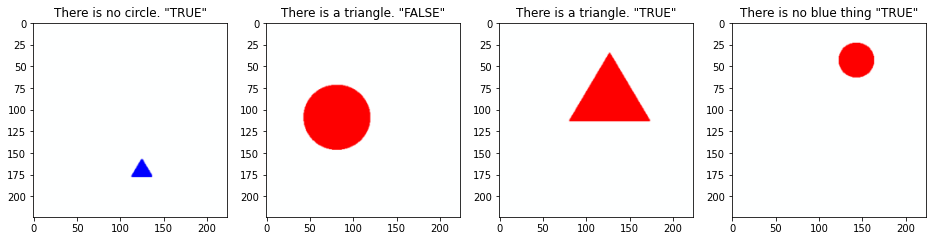

In [7]:
viz.show_samples(ds_train)

In [8]:
import sys

# list(sys.modules.keys())


In [9]:
import numpy as np
import torch

from cvqa.commons import traintracks

trainer = trainers.VQATrainer(log_dir='runs', progressbar='epochs')
# trainer = trainers.VQATrainer(progressbar='epochs')

def train_model(model, lr=1e-4, epochs=10, batch_size=32):
    
    tracker = traintracks.TrainTracker(root='traintracks/eval')
    tracker.save_module(sys.modules['cvqa.models2'])
    tracker.log_conf(model.args)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss, train_acc, dev_acc = trainer.train(
        model, ds_train, ds_dev, 
        optimizer, traintracker=tracker, num_epochs=epochs, batch_size=batch_size
    )
    
    return {
        'train_loss': train_loss, 
        'train_acc': train_acc, 
        'dev_acc': dev_acc
    }

In [10]:
from cvqa.vis_models import StructuredImageModel

def build_model(args):
    img_model = StructuredImageModel(ds_train, args['d_o'])
    return models2.MostBasicModel(ds_train.vocab, ds_train.ans_vocab, img_model, args)

In [11]:

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

args = models2.default_args()
args['d_a'] = 4
args['d_w'] = args['d_c'] = 16
args['d_o'] = 16
args['d_k'] = 8
    
model = build_model(args)

print(trainer.evaluate(model, torch.utils.data.DataLoader(ds_train, batch_size=32)))

train_metrics = train_model(model, lr=3e-3, epochs=50, batch_size=32)

KeyError: 'numerics_img'

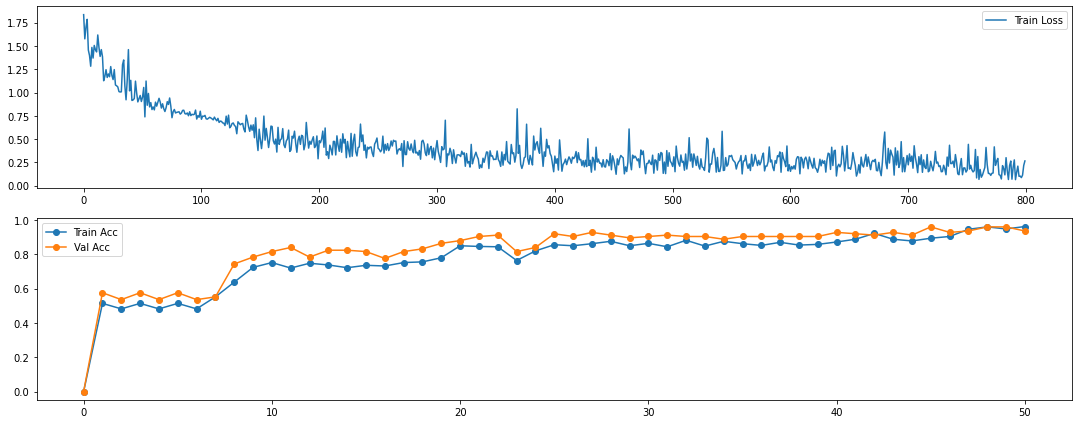

In [315]:
viz.plot_training(**train_metrics)

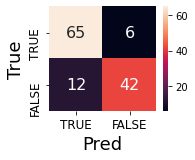

In [169]:
y_true, y_pred = trainer.get_predictions(model, ds_dev)
viz.one_word_conf_mat(y_true, y_pred, ds_dev.ans_vocab)

Sample index: 28
Prompt: This thing is a triangle.
Decoded encoded prompt: This thing is a triangle. <pad> <pad>
True: TRUE
Pred: FALSE


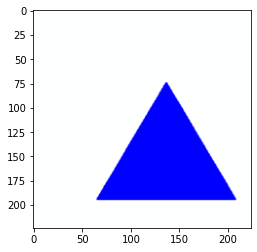

In [195]:
viz.test_natural_sample(model, ds_dev)

In [235]:
import pandas as pd

y_true, y_pred = trainer.get_predictions(model, ds_train)

questions = []
y_true_str = []
y_pred_str = []
for i, s in enumerate(ds_train.samples):
    questions.append(s['prompt'])
    y_true_str.append(ds_train.ans_vocab.string(y_true[i]))
    y_pred_str.append(ds_train.ans_vocab.string(y_pred[i]))
    
    
res = pd.DataFrame({
    'question': questions,
    'y_true': y_true_str,
    'y_pred': y_pred_str
})

res[res['y_true'] != res['y_pred']]

,question,y_true,y_pred
23,There is a thing of grey color.,FALSE,TRUE
47,There is a object of grey color.,FALSE,TRUE
54,There is a thing of red color.,TRUE,FALSE
67,There is a item of blue color.,TRUE,FALSE
86,There is a blue object.,TRUE,FALSE
93,There is a thing of grey color.,FALSE,TRUE
103,There is a object of blue color.,TRUE,FALSE
105,There is a grey item.,FALSE,TRUE
109,There is a grey thing.,FALSE,TRUE
118,There is a blue item.,TRUE,FALSE
